In [1]:
%matplotlib inline

from nilearn import plotting
import nibabel as nib
import os
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np


In [2]:
si2_img = nib.load(os.path.join('..', 'zmeta_rocs', 'pre', 'scaled', 'varcopes.nii.gz'))
hatbeta_img = nib.load(os.path.join('..', 'zmeta_rocs', 'pre', 'scaled', 'copes.nii.gz'))
tau2_img = nib.load(os.path.join('..', 'zmeta_rocs', 'results', 'megaMFX', 'stats', 'mean_random_effects_var1.nii.gz'))

In [3]:
si2 = si2_img.get_data()
si2.shape
num_studies = si2.shape[3]

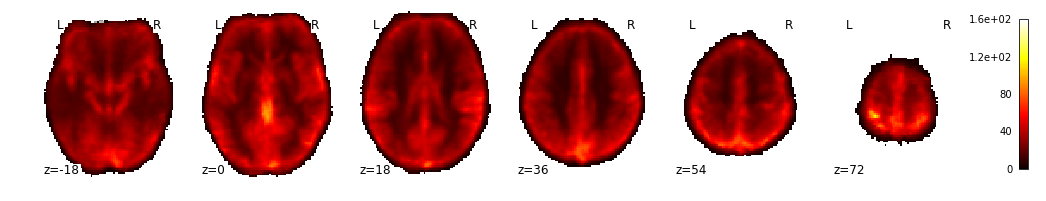

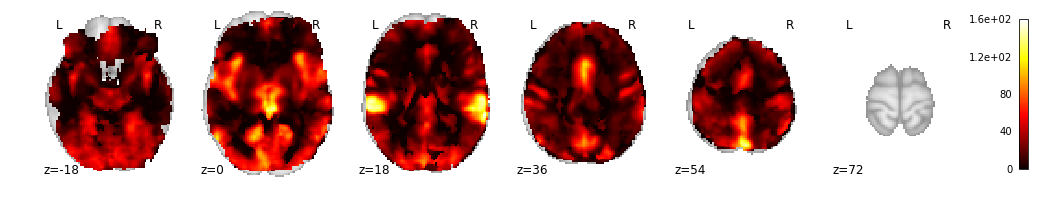

In [53]:
# Root square of the avg squared study standard error
mean_si2 = np.mean(si2, axis=3)

plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(mean_si2)), colorbar=True, display_mode='z', vmax=160, 
                      cut_coords = range(-18, 74, 18))
plotting.plot_stat_map(new_img_like(tau2_img, np.sqrt(tau2)), colorbar=True, display_mode='z', vmax=160,
                      cut_coords = range(-18, 74, 18))

/Users/cmaumet/anaconda/envs/r-env/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


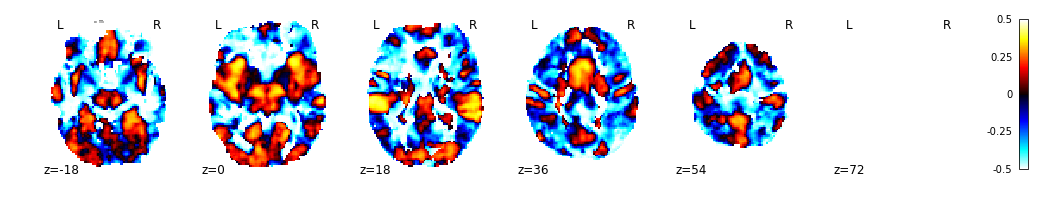

In [54]:
plotting.plot_stat_map(new_img_like(tau2_img, tau2/(tau2+mean_si2)-0.5), colorbar=True, display_mode='z', vmax=0.5,
                      cut_coords = range(-18, 74, 18))

In [4]:
tau2=tau2_img.get_data()
tau2.shape

(91, 109, 91)

In [5]:
in_mask = np.nonzero(tau2>0)

# 

# plotting.plot_glass_brain(tau2_img, threshold=0)

In [6]:
hatbeta = hatbeta_img.get_data()

### Cochran's Q statistic for heterogeneity

In [7]:
FFX_cope1_img = nib.load(
    os.path.join('..', 'zmeta_rocs', 'results', 'megaFFX_FSL', 'stats', 'cope1.nii.gz'))
FFX_cope1 = FFX_cope1_img.get_data()

In [8]:
from nilearn.image import new_img_like
FFX_cope1_inmask = FFX_cope1[in_mask]

Q = 0
for k in range(num_studies):
    curr_si2 = si2[...,k]
    curr_si2 = curr_si2[in_mask]
    curr_hatbeta = hatbeta[...,k]
    curr_hatbeta = curr_hatbeta[in_mask]
    w_i = np.divide(1, curr_si2)
    Q = Q + np.multiply(w_i, np.square(curr_hatbeta-FFX_cope1_inmask))

Q_inmask = Q
Q = np.zeros(tau2.shape)
Q[in_mask] = Q_inmask
Q_img = new_img_like(tau2_img, Q)

I2_inmask = (Q_inmask-(num_studies-1))/Q_inmask*100
I2 = np.zeros(tau2.shape)
I2[in_mask] = I2_inmask
I2_img = new_img_like(tau2_img, I2)

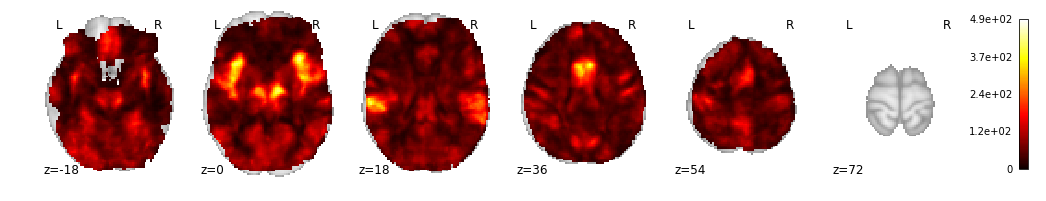

In [57]:
plotting.plot_stat_map(Q_img, colorbar=True, threshold=0, display_mode='z',
                      cut_coords = range(-18, 74, 18))

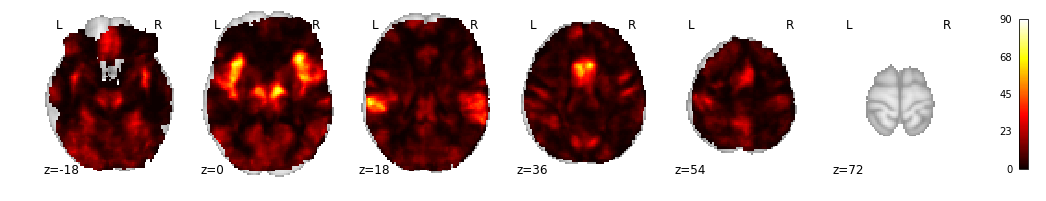

In [59]:
import scipy

Qp_inmask = scipy.stats.chi2.sf(Q_inmask, num_studies-1, loc=0, scale=1)
Qp_mlog10 = np.zeros(tau2.shape)
Qp_mlog10[in_mask] = -np.log10(Qp_inmask)
Qp_mlog10_img = new_img_like(tau2_img, Qp_mlog10)
plotting.plot_stat_map(Qp_mlog10_img, colorbar=True, threshold=0,display_mode='z',
                      cut_coords = range(-18, 74, 18))

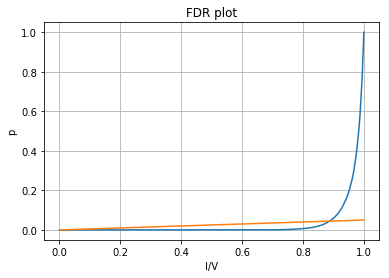

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def fdr(p,q):
#     Adapated from Thomas Nichols's implementation for Matlab available at: 
# https://www2.warwick.ac.uk/tenichols/software/fdr/FDR.m

    p = np.sort(p)
    V = len(p)
    I = range(1, V+1)
    
    cVID = 1
    cVN = sum(np.divide(1, range(1, V+1)))
    
    thresh_val = (np.divide(I, V)*q/cVID)

    plt.plot(np.divide(I, V), p)
    plt.plot(np.divide(I, V), thresh_val)

    plt.xlabel('I/V')
    plt.ylabel('p')
    plt.title('FDR plot')
    plt.grid(True)
    plt.show()
    
    pID = np.max(p[p<=thresh_val])
    return(pID)

pFDR = fdr(Qp_inmask, 0.05)

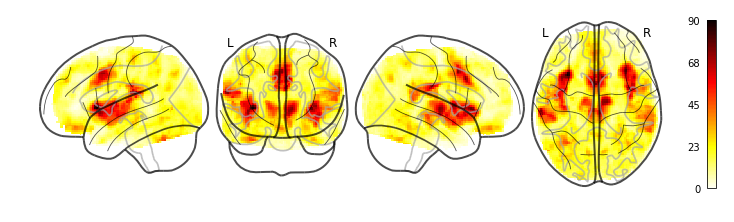

In [12]:
plotting.plot_glass_brain(Qp_mlog10_img, colorbar=True, threshold=-np.log10(pFDR), display_mode='lyrz')

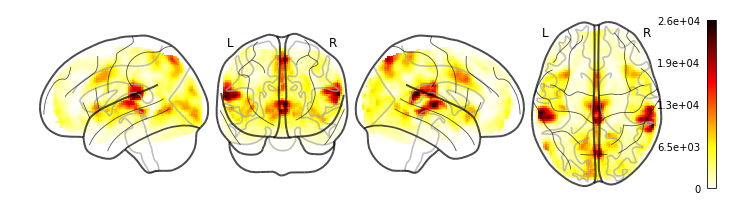

In [13]:
plotting.plot_glass_brain(tau2_img, colorbar=True, threshold=-np.log10(pFDR), display_mode='lyrz')

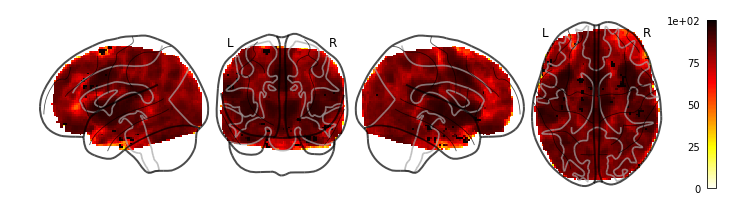

In [14]:
plotting.plot_glass_brain(I2_img, colorbar=True, threshold=0, vmax=100, display_mode='lyrz')

In [15]:
curr_hatbeta.shape

(192232,)

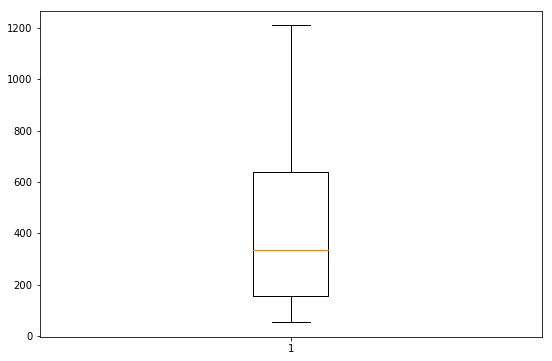

In [21]:
def box_plot(values):
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(values.flatten())


# Mumford 2009: Average over voxels within the interquartile of the nonzero between-study variances

q75, q25 = np.percentile(tau2[tau2>0], [75 ,25])
iqr = q75 - q25

# interquartile of the nonzero between-study variances
# boxplot(tau2[tau2>0])
box_plot(tau2[(tau2<=q75) & (tau2>=q25)])

within_interquartile = np.nonzero((tau2<=q75) & (tau2>=q25))

[   30.28869057    26.63625145    18.81457329    20.90049362   874.75335693
   965.30450439  1193.046875    1762.8984375   1323.6854248   2307.5012207
  1425.92871094   326.2166748     55.74742126    74.05918884  2310.58349609
  1982.34204102  1687.75524902  1655.80090332   279.61077881   586.33416748
   385.56600952]


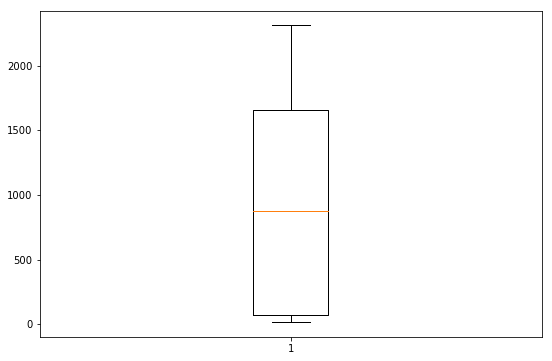

In [24]:

summary_si2 = np.zeros(num_studies)

for study in range(num_studies):
    this_study_si2 = si2[...,study]
    summary_si2[study] = np.mean(this_study_si2[within_interquartile])
    
print(summary_si2)
#     (tau2<=q75) & (tau2>=q25)
box_plot(summary_si2)


# print(min(summary_si2))
# print(max(summary_si2))

# q75, q25 = np.percentile(summary_si2, [75 ,25])
# iqr = q75 - q25
# print(q25)
# print(q75)

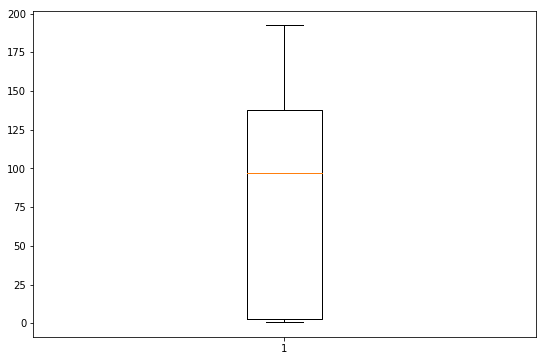

In [25]:
num_subjects_per_study = [25, 25, 20, 20, 9, 9, 9, 12, 12, 12, 12, 13, 32, 24, 14, 14, 12, 12, 16, 16, 16]
box_plot(np.divide(summary_si2, num_subjects_per_study))


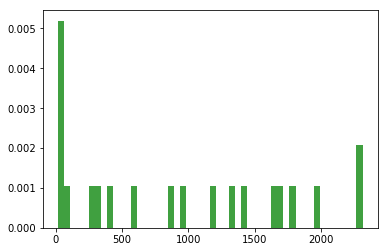

In [18]:
n, bins, patches = plt.hist(summary_si2.flatten(), 50, normed=1, facecolor='g', alpha=0.75)

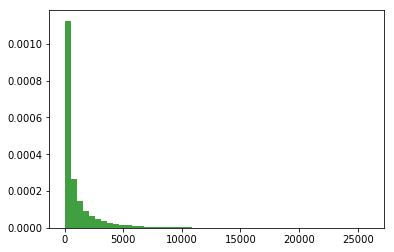

In [19]:
n, bins, patches = plt.hist(tau2[tau2>0].flatten(), 50, normed=1, facecolor='g', alpha=0.75)

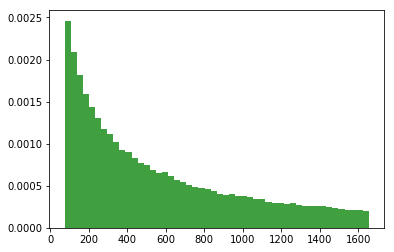

In [20]:
n, bins, patches = plt.hist(tau2[(tau2<=q75) & (tau2>=q25)].flatten(), 50, normed=1, facecolor='g', alpha=0.75)